In [1]:
import sqlite3
import pandas as pd
import plotly.express as px
from pandasql import sqldf, load_meat, load_births
from pysqldf import SQLDF
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from bokeh.models import Legend, LegendItem
from bokeh.palettes import Category20, Colorblind, Spectral11, Spectral4
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, FactorRange, ColorBar, LinearColorMapper, Title
from bokeh.io import show, output_notebook, export_svg
from bokeh.transform import factor_cmap, transform
from sklearn.preprocessing import MinMaxScaler
from plotly.subplots import make_subplots
from bokeh.layouts import gridplot
from bokeh.core.properties import value
from bokeh.models import SingleIntervalTicker, BasicTicker

# Set the display.max_rows option to None to display all rows
pd.set_option('display.max_rows', None)

# Set the display.max_columns option to None to display all columns
pd.set_option('display.max_columns', None)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

def split_and_insert_break(organism):
    if len(organism) >11:
        words = organism.split(' ')
        for i in range(len(words)):
            words[i] = words[i] + '<br>'
            organism = ' '.join(words)
    return organism 



def plot_dict_of_dfs(dfs):
    output_notebook()
    plots = []
    for key, df in dfs.items():
        for col in df.columns:
            print(col)
            print()
            if pd.api.types.is_numeric_dtype(df[col]):
                hist, edges = np.histogram(df[col].dropna(), bins=50)
                p = figure(title=f"Histogram of {col}", tools='', background_fill_color="#fafafa")
                p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], fill_color="navy", line_color="white", alpha=0.5)
                p.y_range.start = 0
                p.xaxis.axis_label = 'Value'
                p.yaxis.axis_label = 'Frequency'
                p.grid.grid_line_color="white"
#             elif col == 'score':
#                 continue
            else:
                data = df[col].value_counts()
                source = ColumnDataSource(data=dict(x=data.index, y=data.values))
                p = figure(x_range=data.index.tolist(), plot_height=300, toolbar_location=None, title=f"Counts of {col}")
                p.vbar(x='x', top='y', width=0.9, source=source)

            plots.append(p)

    grid = gridplot(plots, ncols=3)

    show(grid)

In [2]:
palette = ['#4169e1',
'#e9967a',
'#dc143c',
'#00ffff',
'#00bfff',
'#f4a460',
'#9370db',
'#0000ff',
'#ff6347',
'#d8bfd8',
'#ff00ff',
'#db7093',
'#f0e68c',
'#ffff54',
'#6495ed',
'#dda0dd',
'#87ceeb',
'#bc8f8f',
'#663399',
'#008080',
'#b8860b',
'#bdb76b',
'#4682b4',
'#000080',
'#d2691e',
'#9acd32',
'#20b2aa',
'#cd5c5c',
'#32cd32',
'#8fbc8f',
'#8b008b',
'#b03060',
'#d2b48c',
'#66cdaa',
'#a9a9a9',
'#dcdcdc',
'#2f4f4f',
'#556b2f',
'#8b4513',
'#6b8e23',
'#2e8b57',
'#191970',
'#708090',
'#8b0000',
'#483d8b',
'#008000',
'#ff4500',
'#ffa500',
'#ffd700',
'#c71585',
'#0000cd',
'#7cfc00',
'#00ff00',
'#9400d3',
'#ba55d3',
'#00fa9a',
'#ff1493',
'#afeeee',
'#ee82ee',
'#98fb98',
'#7fffd4',
'#ff69b4',
'#ffe4c4',
'#ffb6c1']

In [3]:
conn = sqlite3.connect('mprabase_v4_9.3.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cur.fetchall()

tablesofdatabase = {}
for table in tables:
    query = f"SELECT * from {table[0]}"
    
    tablesofdatabase[table[0]] = pd.read_sql_query(query, conn)


In [85]:
pysqldf = lambda q: sqldf(q, globals())

counts = {}
for key in tablesofdatabase.keys():
    locals()[key] = tablesofdatabase[key]
    query = f"SELECT COUNT(*) FROM {key};"
    result = pysqldf(query)
    counts[key] = result.values[0][0]

In [86]:
columnlists={}
print("------------Columns------------")
print()
for i in tablesofdatabase:
    columnlists[i]=tablesofdatabase[i].columns.tolist()
    print(i, ':   ', columnlists[i])

print()
print("------------Columns------------")


------------Columns------------

designed_library :    ['library_id', 'library_name', 'datasets_id', 'number_of_elements']
library_sequence :    ['library_element_id', 'library_id', 'genome_build', 'element_coordinate', 'library_element_name', 'sequence']
element_score :    ['element_sample_id', 'library_element_name', 'score', 'library_element_id', 'sample_id', 'library_id']
element_rep_score :    ['element_rep_id', 'sample_id', 'library_element_id', 'REP1', 'REP2', 'REP3', 'REP4', 'REP5', 'REP6', 'REP7', 'REP8', 'REP9', 'REP10', 'REP11', 'REP12', 'REP13', 'REP14', 'REP15', 'REP16', 'REP17', 'REP18', 'REP19', 'REP20', 'REP21', 'REP22', 'REP23', 'REP24', 'REP25']
datasets :    ['datasets_id', 'datasets_name', 'PMID', 'GEO_number', 'SRP_number', 'Reference', 'labs']
sample :    ['sample_id', 'sample_name', 'Library_strategy', 'Organism', 'Cell_line_tissue', 'library_id', 'element_position', 'DNA_RNA_reps', 'description', 'GenomeBrowser', 'rep_type']

------------Columns------------


In [157]:
df_datasets = pd.merge(designed_library, datasets, on='datasets_id', how='inner')
df_datasets.head()

,library_id,library_name,datasets_id,number_of_elements,datasets_name,PMID,GEO_number,SRP_number,Reference,labs
0,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
1,DS0021-LID01,Klein_Cloned_array_oligo_library_9_MPRA_libraries,DS0021,2439,Klein_MPRA_HepG2,33046894,GSE142696,,"A systematic evaluation of the design, orienta...","Shendure,Ahituv"
2,DS0021-LID02,Klein_Cloned_array_oligo_library_shortMedLong,DS0021,6908,Klein_MPRA_HepG2,33046894,GSE142696,,"A systematic evaluation of the design, orienta...","Shendure,Ahituv"
3,DS0021-LID03,Klein_Cloned_array_oligo_library_forwardreverse,DS0021,2337,Klein_MPRA_HepG2,33046894,GSE142696,,"A systematic evaluation of the design, orienta...","Shendure,Ahituv"
4,DS0002-LID01,Klein_STARR_Ortholog,DS0002,5218,Klein_STARR_HepG2,30045748,GSE113978,,Functional characterization of enhancer evolut...,Shendure


In [160]:
df_library = pd.merge(designed_library, library_sequence, on='library_id', how='inner')
#df_library = pd.merge(df_library, element_score, on='library_id', how='inner')
df_library = pd.merge(df_library, sample, on='library_id', how='inner')
df_library.head()

,library_id_x,library_name_x,datasets_id,number_of_elements_x,library_element_id,genome_build,element_coordinate,library_element_name,sequence,sample_id,sample_name,Library_strategy,Organism,Cell_line_tissue,element_position,DNA_RNA_reps,description,GenomeBrowser,rep_type,library_id_y,library_name_y,number_of_elements_y,datasets_name,PMID,GEO_number,SRP_number,Reference,labs
0,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000001,hg19,chr10:11917871-11917984,A:HNF4A-ChMod_chr10:11917871-11917984_[chr10:1...,AGGACCGGATCAACTGAGGCTGCTGGAACTCAGTGGTTGATAAACA...,DS0001-SID01,Inoue_Mutant_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Mutant integrase,DS0001-SID01_hg19.bed;\nDS0001-SID01_hg18.bed,,DS0001-LID01,Cloned_array_oligo_library,2440,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
1,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000001,hg19,chr10:11917871-11917984,A:HNF4A-ChMod_chr10:11917871-11917984_[chr10:1...,AGGACCGGATCAACTGAGGCTGCTGGAACTCAGTGGTTGATAAACA...,DS0001-SID02,Inoue_Wild-type_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Wild-type integrase,DS0001-SID02_hg18.bed;DS0001-SID02_hg19.bed,,DS0001-LID01,Cloned_array_oligo_library,2440,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
2,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000002,hg19,chr10:34165653-34165745,A:HNF4A-ChMod_chr10:34165653-34165745_[chr10:3...,AGGACCGGATCAACTTCACATCTGCTCTGGATGGTGCACATGGAGA...,DS0001-SID01,Inoue_Mutant_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Mutant integrase,DS0001-SID01_hg19.bed;\nDS0001-SID01_hg18.bed,,DS0001-LID01,Cloned_array_oligo_library,2440,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
3,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000002,hg19,chr10:34165653-34165745,A:HNF4A-ChMod_chr10:34165653-34165745_[chr10:3...,AGGACCGGATCAACTTCACATCTGCTCTGGATGGTGCACATGGAGA...,DS0001-SID02,Inoue_Wild-type_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Wild-type integrase,DS0001-SID02_hg18.bed;DS0001-SID02_hg19.bed,,DS0001-LID01,Cloned_array_oligo_library,2440,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
4,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000003,hg19,chr10:52009954-52010059,A:HNF4A-ChMod_chr10:52009954-52010059_[chr10:5...,AGGACCGGATCAACTTCTTTAGATGGGGGATATATTCTTCAACCTG...,DS0001-SID01,Inoue_Mutant_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Mutant integrase,DS0001-SID01_hg19.bed;\nDS0001-SID01_hg18.bed,,DS0001-LID01,Cloned_array_oligo_library,2440,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"


In [166]:
df_total = pd.merge(df_library, df_datasets, on='datasets_id', how='inner')
df_total = df_total.drop(columns=['number_of_elements_y', 'library_name_y', 'library_id_y'])
df_total = df_total.rename(columns={'library_id_x': 'library_id', 'library_name_x': 'library_name', 'number_of_elements_x': 'number_of_elements'})
df_total.head()

,library_id,library_name,datasets_id,number_of_elements,library_element_id,genome_build,element_coordinate,library_element_name,sequence,sample_id,sample_name,Library_strategy,Organism,Cell_line_tissue,element_position,DNA_RNA_reps,description,GenomeBrowser,rep_type,datasets_name,PMID,GEO_number,SRP_number,Reference,labs
0,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000001,hg19,chr10:11917871-11917984,A:HNF4A-ChMod_chr10:11917871-11917984_[chr10:1...,AGGACCGGATCAACTGAGGCTGCTGGAACTCAGTGGTTGATAAACA...,DS0001-SID01,Inoue_Mutant_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Mutant integrase,DS0001-SID01_hg19.bed;\nDS0001-SID01_hg18.bed,,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
1,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000001,hg19,chr10:11917871-11917984,A:HNF4A-ChMod_chr10:11917871-11917984_[chr10:1...,AGGACCGGATCAACTGAGGCTGCTGGAACTCAGTGGTTGATAAACA...,DS0001-SID02,Inoue_Wild-type_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Wild-type integrase,DS0001-SID02_hg18.bed;DS0001-SID02_hg19.bed,,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
2,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000002,hg19,chr10:34165653-34165745,A:HNF4A-ChMod_chr10:34165653-34165745_[chr10:3...,AGGACCGGATCAACTTCACATCTGCTCTGGATGGTGCACATGGAGA...,DS0001-SID01,Inoue_Mutant_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Mutant integrase,DS0001-SID01_hg19.bed;\nDS0001-SID01_hg18.bed,,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
3,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000002,hg19,chr10:34165653-34165745,A:HNF4A-ChMod_chr10:34165653-34165745_[chr10:3...,AGGACCGGATCAACTTCACATCTGCTCTGGATGGTGCACATGGAGA...,DS0001-SID02,Inoue_Wild-type_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Wild-type integrase,DS0001-SID02_hg18.bed;DS0001-SID02_hg19.bed,,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
4,DS0001-LID01,Cloned_array_oligo_library,DS0001,2440,DS0001-LID01-EID00000003,hg19,chr10:52009954-52010059,A:HNF4A-ChMod_chr10:52009954-52010059_[chr10:5...,AGGACCGGATCAACTTCTTTAGATGGGGGATATATTCTTCAACCTG...,DS0001-SID01,Inoue_Mutant_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,5'/3',3,Mutant integrase,DS0001-SID01_hg19.bed;\nDS0001-SID01_hg18.bed,,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"


In [87]:
summarydata = pd.DataFrame(counts, index=['count'])
summarydata

,designed_library,library_sequence,element_score,element_rep_score,datasets,sample
count,72,381661,638162,555603,51,130


In [89]:
len(tablesofdatabase['designed_library']['datasets_id'].unique())

49

In [90]:
len(tablesofdatabase['designed_library']['library_id'].unique())

72

In [91]:
tablesofdatabase['library_sequence'].head()

,library_element_id,library_id,genome_build,element_coordinate,library_element_name,sequence
0,DS0003-LID01-EID00000001,DS0003-LID01,,,hg18:chr2:210861483-210861650113:V_AHRARNT_02:...,
1,DS0003-LID01-EID00000002,DS0003-LID01,,,hg18:chr2:210861483-210861650113:V_AP2GAMMA_01...,
2,DS0003-LID01-EID00000003,DS0003-LID01,,,hg18:chr2:210861483-210861650113:V_COUPTF_Q6:C...,
3,DS0003-LID01-EID00000004,DS0003-LID01,,,hg18:chr2:210861483-210861650113:V_GATA4_Q3:AG...,
4,DS0003-LID01-EID00000005,DS0003-LID01,,,hg18:chr2:210861483-210861650113:V_HNF1_C:AGTT...,


In [92]:
len(tablesofdatabase['library_sequence']['library_id'].unique())

19

In [93]:
tablesofdatabase['element_score'].head()

,element_sample_id,library_element_name,score,library_element_id,sample_id,library_id
0,DS0002-SID02-EID00006859,X:87816252-87816446,-0.52987,DS0002-LID02-EID00006859,DS0002-SID02,DS0002-LID02
1,DS0002-SID02-EID00006858,X:87815952-87816146,0.466077,DS0002-LID02-EID00006858,DS0002-SID02,DS0002-LID02
2,DS0002-SID02-EID00006857,X:87815752-87815946,0.832129,DS0002-LID02-EID00006857,DS0002-SID02,DS0002-LID02
3,DS0002-SID02-EID00006856,X:87815552-87815746,0.223529,DS0002-LID02-EID00006856,DS0002-SID02,DS0002-LID02
4,DS0002-SID02-EID00006855,X:87815052-87815246,-0.038264,DS0002-LID02-EID00006855,DS0002-SID02,DS0002-LID02


In [94]:
len(tablesofdatabase['element_score']['sample_id'].unique())

36

In [95]:
tablesofdatabase['element_rep_score'].head()

,element_rep_id,sample_id,library_element_id,REP1,REP2,REP3,REP4,REP5,REP6,REP7,REP8,REP9,REP10,REP11,REP12,REP13,REP14,REP15,REP16,REP17,REP18,REP19,REP20,REP21,REP22,REP23,REP24,REP25
0,DS0001-SID01-REP-EID00000001,DS0001-SID01,DS0001-LID01-EID00000001,0.933786,0.97131,0.964106,,,,,,,,,,,,,,,,,,,,,,
1,DS0001-SID01-REP-EID00000002,DS0001-SID01,DS0001-LID01-EID00000002,0.977862,0.980376,1.129022,,,,,,,,,,,,,,,,,,,,,,
2,DS0001-SID01-REP-EID00000003,DS0001-SID01,DS0001-LID01-EID00000003,0.890682,0.881488,0.869042,,,,,,,,,,,,,,,,,,,,,,
3,DS0001-SID01-REP-EID00000004,DS0001-SID01,DS0001-LID01-EID00000004,1.114308,1.163713,1.147061,,,,,,,,,,,,,,,,,,,,,,
4,DS0001-SID01-REP-EID00000005,DS0001-SID01,DS0001-LID01-EID00000005,0.742129,0.776007,0.777036,,,,,,,,,,,,,,,,,,,,,,


In [96]:
len(tablesofdatabase['element_rep_score']['sample_id'].unique())

31

In [97]:
tablesofdatabase['datasets'].head() 

,datasets_id,datasets_name,PMID,GEO_number,SRP_number,Reference,labs
0,DS0001,Inoue_MPRA_HepG2,27831498,GSE83894,,A systematic comparison reveals substantial di...,"Shendure,Ahituv"
1,DS0002,Klein_STARR_HepG2,30045748,GSE113978,,Functional characterization of enhancer evolut...,Shendure
2,DS0003,Smith_MPRA_HepG2,23892608,,SRP018414,Massively parallel decoding of mammalian regul...,"Ahituv, Ovcharenko,Shendure"
3,DS0004,Stark_STARR_SEQ,23328393,GSE40739,,Genome-Wide Quantitative Enhancer Activity Map...,Stark
4,DS0005,Wang_HiDRA_GM12878,30568279,GSE104001,,High-resolution genome-wide functional dissect...,"Kellis, Claussnitzer"


In [98]:
len(tablesofdatabase['datasets']['datasets_id'].unique())

51

In [99]:
tablesofdatabase['sample'].head()

,sample_id,sample_name,Library_strategy,Organism,Cell_line_tissue,library_id,element_position,DNA_RNA_reps,description,GenomeBrowser,rep_type
0,DS0001-SID01,Inoue_Mutant_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,DS0001-LID01,5'/3',3,Mutant integrase,DS0001-SID01_hg19.bed;\nDS0001-SID01_hg18.bed,
1,DS0001-SID02,Inoue_Wild-type_integrase_HepG2,lentiMPRA,Homo sapiens,HepG2,DS0001-LID01,5'/3',3,Wild-type integrase,DS0001-SID02_hg18.bed;DS0001-SID02_hg19.bed,
2,DS0002-SID01,Klein_STARR_Tiling_HepG2,STARR-seq,Homo sapiens,HepG2,DS0002-LID01,,3,Tiling,DS0002-SID01_hg19.bed,
3,DS0002-SID02,Klein_STARR_Orthologs_HepG2,STARR-seq,Homo sapiens,HepG2,DS0002-LID01,,3,Orthologs,DS0002-SID02_hg19.bed,
4,DS0003-SID01,Smith_MPRA_mouse_synthetic,plasmidMPRA,Mus musculus,liver,DS0003-LID01,,3,mouse_MPRA,DS0003-SID01_hg18.bed,None


In [100]:
len(tablesofdatabase['sample']['library_id'].unique())

72

In [168]:
merged_df = pd.merge(tablesofdatabase['designed_library'], tablesofdatabase['datasets'], on='datasets_id', how='outer')
final_df = pd.merge(merged_df, tablesofdatabase['sample'], on='library_id', how='outer')

In [169]:
final_df['Library_strategy'] = final_df['Library_strategy'].str.replace('\n', '')

In [170]:
grouped = final_df.groupby(['Organism','Library_strategy','Cell_line_tissue']).describe()['sample_id']['count']

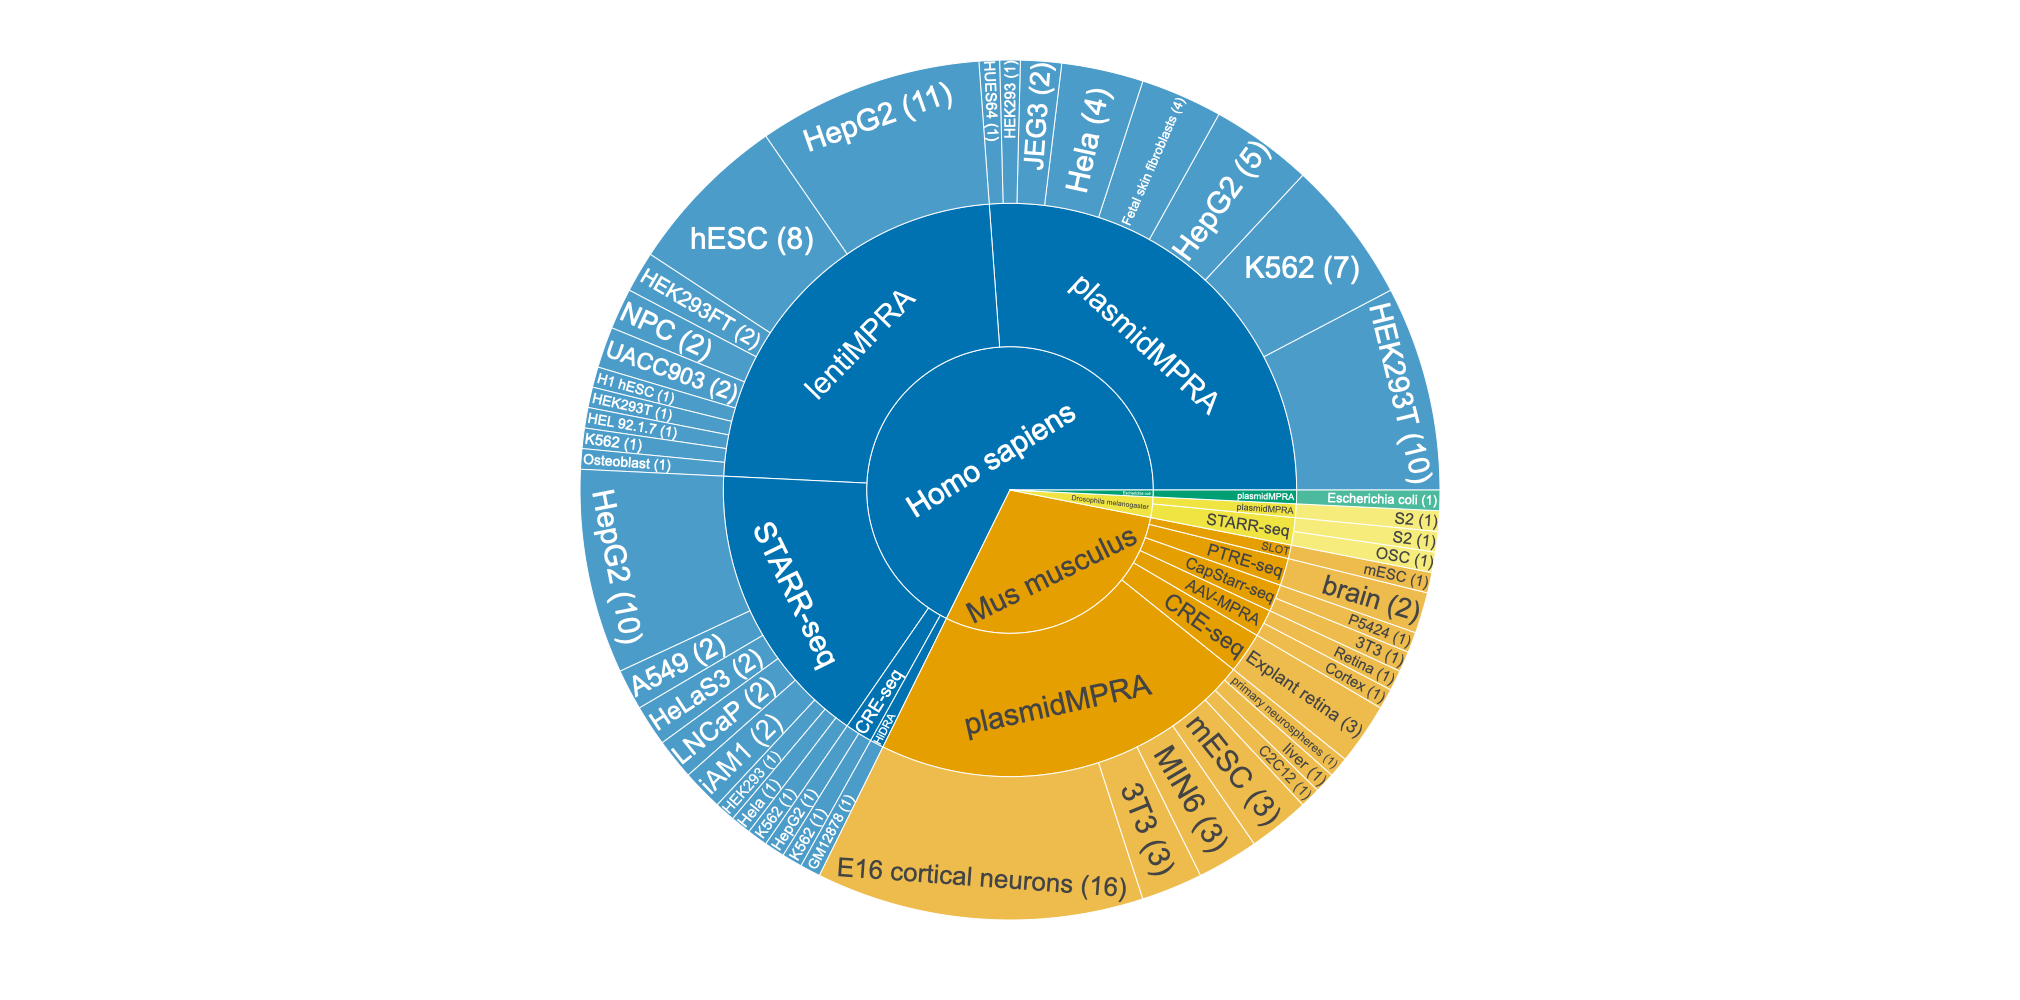

In [171]:
#https://plotly.com/python/sunburst-charts/?_ga=2.93626589.1720091979.1695947763-1327420249.1695947763

grouped2 = pd.DataFrame(grouped.groupby(['Organism', 'Library_strategy','Cell_line_tissue']).sum())
total = grouped2.groupby(['Organism'])['count'].sum().sum()
total_per_organism = grouped2.groupby(['Organism'])['count'].sum()
total_per_organism_library = grouped2.groupby(['Organism','Library_strategy'])['count'].sum()
total_per_organism_library_tissue = pd.DataFrame(grouped2.groupby(['Organism','Library_strategy','Cell_line_tissue'])['count'].sum())

percentageoforganism =grouped2.groupby(['Organism'])['count'].apply(lambda x: x.sum() / total *100)
librarypercentageoforganism = grouped2.groupby(['Organism', 'Library_strategy'])['count'].apply(lambda x: (x.sum() / total_per_organism[x.name[0]]) * 100)
librarypercentageoforganism = librarypercentageoforganism.groupby(level=[0,1]).sum()  / 100 * percentageoforganism
tissuepercentageoflibraryperorganism = pd.DataFrame(grouped2.groupby(['Organism','Library_strategy'])['count'].apply(lambda x: x/x.sum()*100))
unique_index = pd.Index(tissuepercentageoflibraryperorganism.index).unique()
new_df = pd.DataFrame(index=unique_index, data=tissuepercentageoflibraryperorganism['count']).reset_index()
new_index = [(x[0], x[1], x[-1]) for x in new_df['index']]
new_df['index'] = new_index
new_df.index = new_df['index']
grouped2['percentage'] = new_df['count']
grouped2['percentage'] = grouped2['percentage']  / 100 * librarypercentageoforganism
df = grouped2.reset_index()

df['Cell_line_tissue'] = df['Cell_line_tissue'] + ' (' + df['count'].astype(str) + ')'


fig = px.sunburst(df, path=['Organism', 'Library_strategy', 'Cell_line_tissue'], values='percentage',color_discrete_sequence=Colorblind[4])

# Define the layout
layout = go.Layout(
    title=" ",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="RebeccaPurple"
    ),
    showlegend=True,
    autosize=False,
    width=1000,
    height=1000
) 

# Update the layout and traces
fig.update_layout(layout)
fig.update_traces(textfont_size=30)
fig.update_traces(textfont=dict(family="Arial"))

fig.write_image("piechart_MPRA.svg")

fig.show()


In [173]:
df.set_index("Organism")

,Library_strategy,Cell_line_tissue,count,percentage
Organism,,,,
Drosophila melanogaster,STARR-seq,OSC (1),1,0.769231
Drosophila melanogaster,STARR-seq,S2 (1),1,0.769231
Drosophila melanogaster,plasmidMPRA,S2 (1),1,0.769231
Escherichia coli,plasmidMPRA,Escherichia coli (1),1,0.769231
Homo sapiens,CRE-seq,HepG2 (1),1,0.769231
Homo sapiens,CRE-seq,K562 (1),1,0.769231
Homo sapiens,HiDRA,GM12878 (1),1,0.769231
Homo sapiens,STARR-seq,A549 (2),2,1.538462
Homo sapiens,STARR-seq,HEK293 (1),1,0.769231


In [24]:
df = final_df
df['labs'] = df['labs'].astype(str)
df['labs'] = df['labs'].apply(lambda x: ','.join(sorted([i.strip() for i in x.split(',')])))

In [25]:
output_notebook()

grouped = df.groupby(['Organism','labs','Library_strategy']).size().reset_index(name='counts')
pivot_df = grouped.pivot_table(values='counts', index=['Organism', 'labs'], columns='Library_strategy', fill_value=0).reset_index()
library_strategies = pivot_df.columns[2:].tolist()
pivot_df = pivot_df.sort_values(by=['Organism',])
x = [(Organism, labs) for Organism, labs in zip(pivot_df['Organism'], pivot_df['labs'])]
pivot_df['x'] = x

source = ColumnDataSource(pivot_df)
p = figure(x_range=FactorRange(*x), height=1000, width=3000)
p.vbar_stack(library_strategies, x='x', width=0.475, color=[palette[i] for i,v in enumerate(library_strategies)], line_color='white',
             source=source, legend_label=[v for i,v in enumerate(library_strategies)])
p.legend.orientation = "vertical"
p.add_layout(p.legend[0], 'right')
p.legend.title= "MPRA Type"
p.y_range.start = 0
p.xaxis.major_label_orientation = 1.2
p.xgrid.grid_line_color = None
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = "25pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "19pt"
p.yaxis.major_label_text_font_size = "17pt"
p.xaxis.group_text_font_size = "19pt"
p.legend.label_text_font_size = '14pt'
p.legend.title_text_font_size = '16pt'
p.yaxis.axis_label = "Count"
p.x_range = FactorRange(*x, factor_padding=-0.5, group_padding=1.5)
p.x_range.range_padding = 0

show(p)


Loading BokehJS ...

In [26]:
output_notebook()

grouped = df.groupby(['Organism','labs','Cell_line_tissue']).size().reset_index(name='counts')
pivot_df = grouped.pivot_table(values='counts', index=['Organism', 'labs'], columns='Cell_line_tissue', fill_value=0).reset_index()
library_strategies = pivot_df.columns[2:].tolist()
pivot_df = pivot_df.sort_values(by=['Organism',])
x = [(Organism, labs) for Organism, labs in zip(pivot_df['Organism'], pivot_df['labs'])]
pivot_df['x'] = x

source = ColumnDataSource(pivot_df)
p = figure(x_range=FactorRange(*x), height=1000, width=3000)
p.vbar_stack(library_strategies, x='x', width=0.475, color=[palette[i] for i,v in enumerate(library_strategies)], line_color='white',
             source=source, legend_label=[v for i,v in enumerate(library_strategies)])

p.legend.orientation = "vertical"
p.add_layout(p.legend[0], 'right')
p.legend.title= "Cell Type/Tissue"
p.y_range.start = 0
p.xaxis.major_label_orientation = 1.2
p.xgrid.grid_line_color = None
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = "25pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "19pt"
p.yaxis.major_label_text_font_size = "17pt"
p.xaxis.group_text_font_size = "19pt"
p.legend.label_text_font_size = '14pt' 
p.legend.title_text_font_size = '16pt'
p.yaxis.axis_label = "Count"
p.x_range = FactorRange(*x, factor_padding=-0.5, group_padding=1.5)
p.x_range.range_padding = 0

show(p)


Loading BokehJS ...

In [82]:
grouped = df.groupby(['Organism','Cell_line_tissue']).size().reset_index(name='counts')
pivot_df = grouped.pivot_table(values='counts', index=['Organism'], columns='Cell_line_tissue', fill_value=0).reset_index()
library_strategies = pivot_df.columns[1:].tolist()
sortedorganisms = pivot_df.set_index("Organism").T.sum().sort_values().index.tolist()
pivot_df.set_index("Organism", inplace=True)
pivot_df = pivot_df.reindex(sortedorganisms)
pivot_df.reset_index(inplace=True)
x = [Organism for Organism in pivot_df['Organism']]
pivot_df['x'] = x

source = ColumnDataSource(pivot_df)
p = figure(x_range=FactorRange(*x), height=1000, width=800)
p.vbar_stack(library_strategies, x='x', width=0.475, color=[palette[i] for i,v in enumerate(library_strategies)], line_color='white',
             source=source, legend_label=[v for i,v in enumerate(library_strategies)])

p.legend.orientation = "vertical"
p.add_layout(p.legend[0], 'right')
p.legend.title= "Cell Line/Tissue"
p.y_range.start = 0
p.yaxis.ticker = SingleIntervalTicker(interval=10)
p.xaxis.major_label_orientation = 1.2
p.xgrid.grid_line_color = None
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = "25pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "19pt"
p.yaxis.major_label_text_font_size = "17pt"
p.xaxis.group_text_font_size = "19pt"
p.legend.glyph_height = 15
p.legend.glyph_width = 10
p.legend.label_text_font_size = '12pt'
p.legend.title_text_font_size = '16pt' 
p.yaxis.axis_label = "Count"
p.x_range.range_padding = 0

show(p)


In [83]:
grouped = df.groupby(['Organism','Library_strategy']).size().reset_index(name='counts')
pivot_df = grouped.pivot_table(values='counts', index=['Organism'], columns='Library_strategy', fill_value=0).reset_index()
library_strategies = pivot_df.columns[1:].tolist()
sortedorganisms = pivot_df.set_index("Organism").T.sum().sort_values().index.tolist()
pivot_df.set_index("Organism", inplace=True)
pivot_df = pivot_df.reindex(sortedorganisms)
pivot_df.reset_index(inplace=True)
x = [Organism for Organism in pivot_df['Organism']]
pivot_df['x'] = x

source = ColumnDataSource(pivot_df)
p = figure(x_range=FactorRange(*x), height=1000, width=800)
p.vbar_stack(library_strategies, x='x', width=0.475, color=[palette[i] for i,v in enumerate(library_strategies)], line_color='white',
             source=source, legend_label=[v for i,v in enumerate(library_strategies)])

p.legend.orientation = "vertical"
p.add_layout(p.legend[0], 'right')
p.legend.title= "MPRA Type"
p.legend.label_text_font_size = '13pt'
p.y_range.start = 0
p.yaxis.ticker = SingleIntervalTicker(interval=10)
p.xaxis.major_label_orientation = 1.2
p.xgrid.grid_line_color = None
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = "15pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "19pt"
p.yaxis.major_label_text_font_size = "17pt"
p.xaxis.group_text_font_size = "19pt"
p.legend.glyph_height = 15
p.legend.glyph_width = 10
p.legend.label_text_font_size = '15pt'
p.legend.title_text_font_size = '16pt'
p.yaxis.axis_label = "Count"
p.x_range.range_padding = 0

show(p)


In [29]:
order = ["Homo sapiens", "Mus musculus", "Escherichia coli", "Drosophila melanogaster"]
grouped = df.groupby(['Organism','Cell_line_tissue']).size().reset_index(name='counts')
organisms = grouped['Organism'].unique().tolist()
organisms = sorted(organisms, key=lambda x: order.index(x))
organism_cell_line_pairs = list(grouped[['Organism', 'Cell_line_tissue']].itertuples(index=False, name=None))
organism_cell_line_pairs.sort(key=lambda x: order.index(x[0]))
cell_lines_tissues = [pair[1] for pair in organism_cell_line_pairs]

data = {organism: {'counts': [], 'x': []} for organism in organisms}
for organism in organisms:
    for cell_line_tissue in cell_lines_tissues:
        count = grouped[(grouped['Organism'] == organism) & (grouped['Cell_line_tissue'] == cell_line_tissue)]['counts']
        count_value = count.iloc[0] if not count.empty else 0
        if count_value > 0:  
            data[organism]['x'].append(cell_line_tissue)
            data[organism]['counts'].append(count_value)

p = figure(x_range=cell_lines_tissues, height=500, width=1300, title="Cell Line/Tissue Counts by Organism")

vbars = []
colors = Spectral4
for i, organism in enumerate(organisms):
    source = ColumnDataSource(data=data[organism])
    vbar = p.vbar(x='x', top='counts', width=0.9, source=source, color=colors[i])
    vbars.append(vbar)

legend = Legend(items=[
    LegendItem(label=organism, renderers=[vbars[i]]) for i, organism in enumerate(organisms)
], location="top_center", orientation="horizontal")

p.add_layout(legend, 'above')
p.y_range.start = 0
p.xaxis.major_label_orientation = 1.57
p.xgrid.grid_line_color = None
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = "25pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "19pt"
p.yaxis.major_label_text_font_size = "17pt"
p.xaxis.group_text_font_size = "19pt"
p.legend.label_text_font_size = '14pt' 
p.legend.title_text_font_size = '16pt' 
p.yaxis.axis_label = "Count"
p.x_range.range_padding = 0


export_svg(p, filename="celllinecountbyorganism_MPRA.svg")


show(p)


In [30]:
grouped = df.groupby(['Organism','Library_strategy']).size().reset_index(name='counts')
organisms = grouped['Organism'].unique().tolist()
organisms = sorted(organisms, key=lambda x: order.index(x))
cell_lines_tissues = grouped['Library_strategy'].unique().tolist()

data = {'counts': [], 'x': []}
for organism in organisms:
    for cell_line_tissue in cell_lines_tissues:
        data['x'].append((organism, cell_line_tissue))
        count = grouped[(grouped['Organism'] == organism) & (grouped['Library_strategy'] == cell_line_tissue)]['counts']
        data['counts'].append(count.iloc[0] if not count.empty else 0)

source = ColumnDataSource(data=data)
p = figure(x_range=FactorRange(*data['x']), height=500, width=1300, title="MPRA Counts by Organism")
p.vbar(x='x', top='counts', width=0.9, source=source)

p.y_range.start = 0
p.xaxis.major_label_orientation = 1.56
p.xgrid.grid_line_color = None
p.title.text_font_size = '20pt'
p.xaxis.axis_label_text_font_size = "25pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "19pt"
p.yaxis.major_label_text_font_size = "17pt"
p.xaxis.group_text_font_size = "19pt"
p.legend.label_text_font_size = '14pt' 
p.legend.title_text_font_size = '16pt' 
p.yaxis.axis_label = "Count"
p.x_range.range_padding = 0

export_svg(p, filename="mpracountbyorganism_MPRA.svg")

show(p)


/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/bokeh/models/plots.py:766: UserWarning:


You are attempting to set `plot.legend.label_text_font_size` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.


/swst/apps/anaconda3/2021.05_gcc-8.5.0/lib/python3.8/site-packages/bokeh/models/plots.py:766: UserWarning:


You are attempting to set `plot.legend.title_text_font_size` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.


